In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/regression_image_dataset.zip'  # Replace with actual zip path
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
# Step 3: Set Paths
image_folder = '/content/dataset/images'  # change this path
csv_file = '/content/dataset/labels.csv'  # change this path

In [4]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
# Step 4: Load CSV and filter out 'undipped' (-1.0) rows
df = pd.read_csv(csv_file)
df = df[df['label'] != -1.0].reset_index(drop=True)  # Filter out label = -1.0

# Step 5: Load Images and Labels
image_size = (224, 224) # Adjusted to match model input size
X, y = [], []

for index, row in df.iterrows():
    img_path = os.path.join(image_folder, row['filename'])  # column should be named 'filename'
    label = row['label']
    if os.path.exists(img_path):
        image = load_img(img_path, target_size=image_size)
        image = img_to_array(image) / 255.0
        X.append(image)
        y.append(label)

X = np.array(X)
y = np.array(y)

In [5]:
# STEP 5: Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

IMG_SIZE = 224

# Load DenseNet201
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze most layers initially
for layer in base_model.layers[:-100]:  # keep last ~100 layers trainable
    layer.trainable = False
for layer in base_model.layers[-100:]:
    layer.trainable = True

# Custom regression head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.2)(x)
output = Dense(1)(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # smaller LR for fine-tuning
    loss='mean_squared_error',
    metrics=['mae']
)

# Callbacks for stable training
callbacks = [
    EarlyStopping(monitor='val_mae', patience=40, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_mae', factor=0.3, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint("best_densenet201_reg.h5", save_best_only=True, monitor="val_mae", mode="min")
]


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [7]:
# Directly train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=2000,
    batch_size=32
)


Epoch 1/2000
54/54 ━━━━━━━━━━━━━━━━━━━━ 126s 924ms/step - loss: 78.4606 - mae: 7.4893 - val_loss: 68.5138 - val_mae: 6.8782
Epoch 2/2000
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - loss: 55.0764 - mae: 5.9223 - val_loss: 51.8849 - val_mae: 5.6950
Epoch 3/2000
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - loss: 39.0931 - mae: 4.7279 - val_loss: 34.8123 - val_mae: 4.4522
Epoch 4/2000
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - loss: 26.8683 - mae: 3.7153 - val_loss: 23.2237 - val_mae: 3.4641
Epoch 5/2000
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 20.4419 - mae: 3.1572 - val_loss: 17.6448 - val_mae: 2.8727
Epoch 6/2000
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 18.5850 - mae: 2.9526 - val_loss: 15.1129 - val_mae: 2.5067
Epoch 7/2000
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 16.1967 - mae: 2.6471 - val_loss: 13.5578 - val_mae: 2.2366
Epoch 8/2000
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - loss: 15.7611 - mae: 2.5580 - val_loss: 12.4780 - val_mae: 2.0385
Epoch 9/2000
54/54 ━━━

In [8]:
# STEP 7 (UPDATED): Evaluate and predict with MAE, MSE, RMSE, R2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate on validation set
y_pred = model.predict(X_val).flatten()

# Metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step
Mean Absolute Error (MAE): 0.5623
Mean Squared Error (MSE): 0.6069
Root Mean Squared Error (RMSE): 0.7790
R² Score: 0.9603


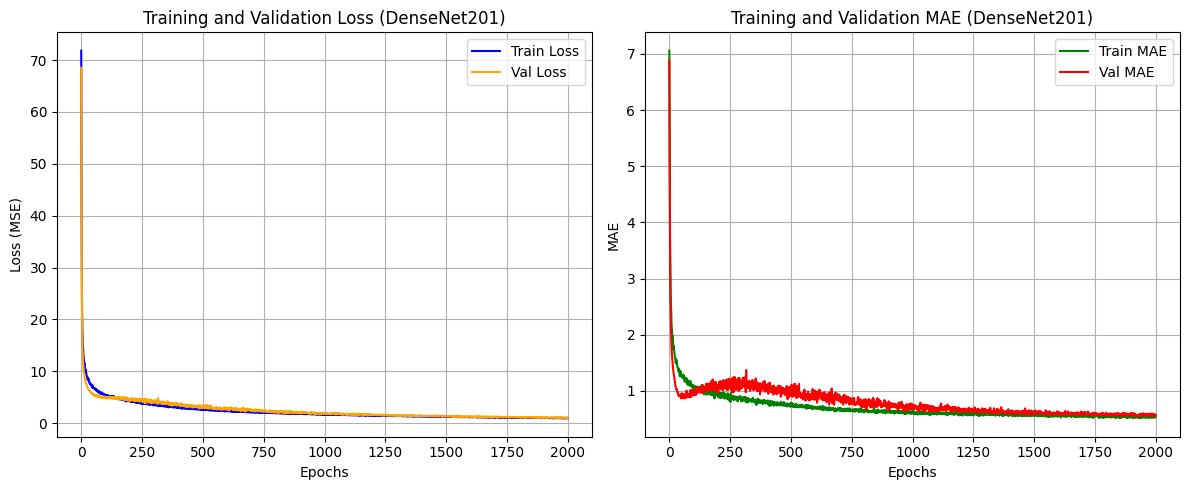

In [9]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss (DenseNet201)')
plt.legend()
plt.grid(True)

# Plot MAE
if 'mae' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE', color='green')
    plt.plot(history.history['val_mae'], label='Val MAE', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('Training and Validation MAE (DenseNet201)')
    plt.legend()
    plt.grid(True)
else:
    print("⚠️ MAE not found in history. Did you compile the model with `metrics=['mae']`?")

plt.tight_layout()
plt.savefig("DenseNet201_loss_and_mae_plot.png", dpi=600, bbox_inches='tight', format='png')
plt.show()


In [10]:
import pandas as pd
from google.colab import files

# STEP 8: Save predicted vs actual for inspection
results = pd.DataFrame({'Actual pH': y_val, 'Predicted pH': y_pred.flatten()})

# Save locally in Colab
csv_path = '/content/DenseNet201_pH_predictions.csv'
results.to_csv(csv_path, index=False)

# Trigger download
files.download(csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

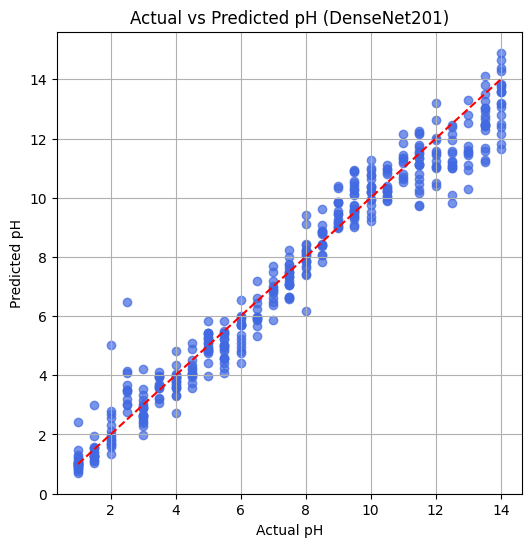

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred, alpha=0.7, color='royalblue')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel("Actual pH")
plt.ylabel("Predicted pH")
plt.title("Actual vs Predicted pH (DenseNet201)")
plt.grid(True)
plt.savefig("DenseNet201_actualvspredicted_plot.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

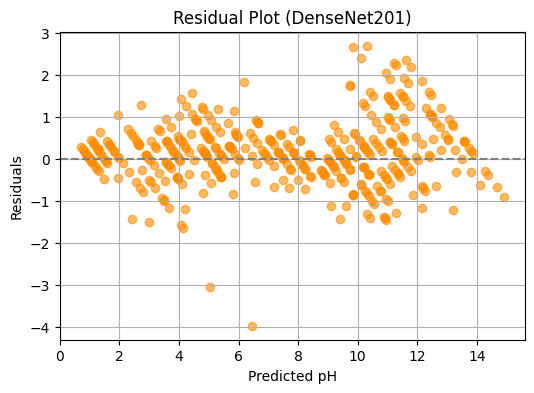

In [12]:
residuals = y_val - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6, color='darkorange')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted pH")
plt.ylabel("Residuals")
plt.title("Residual Plot (DenseNet201)")
plt.grid(True)
plt.savefig("DenseNet201_residual_plot.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

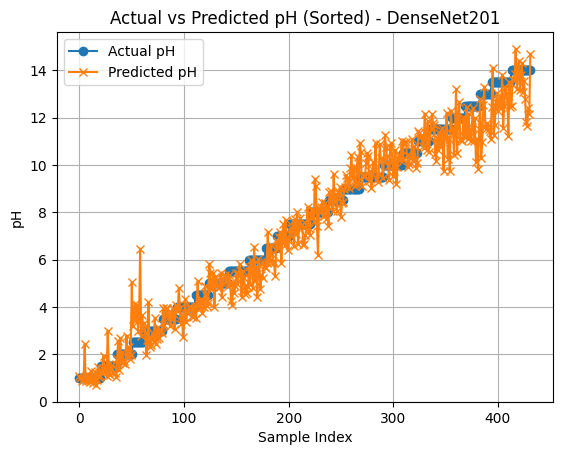

In [13]:
import numpy as np

sorted_indices = np.argsort(y_val)
plt.plot(np.array(y_val)[sorted_indices], label='Actual pH', marker='o')
plt.plot(y_pred[sorted_indices], label='Predicted pH', marker='x')
plt.title("Actual vs Predicted pH (Sorted) - DenseNet201")
plt.xlabel("Sample Index")
plt.ylabel("pH")
plt.legend()
plt.grid(True)
plt.savefig("DenseNet201_actualvspredicted_sorted_plot.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

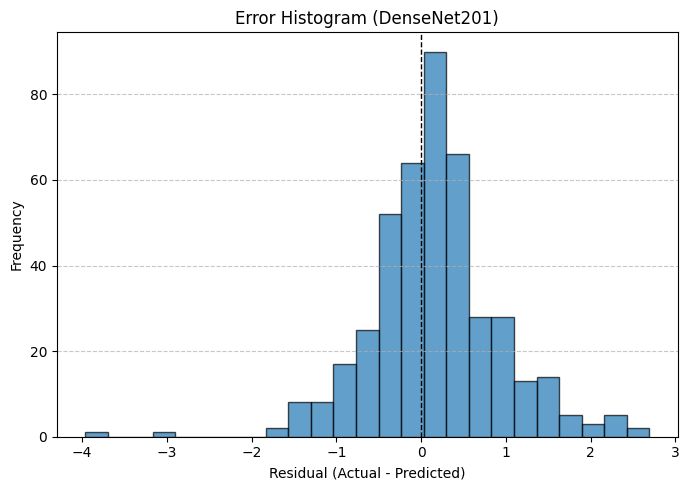

In [14]:
import matplotlib.pyplot as plt

# Residuals (errors)
residuals = y_val - y_pred

# Error histogram
plt.figure(figsize=(7,5))
plt.hist(residuals, bins=25, edgecolor='black', alpha=0.7)
plt.axvline(0, color='k', linestyle='--', linewidth=1)  # reference line at 0
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Error Histogram (DenseNet201)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("DenseNet201_error_histogram.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

In [15]:
from tensorflow.keras.models import load_model
from google.colab import files

# Save the entire model
model_path = "DenseNet201_regression_model_latest.h5"
model.save(model_path)

# Download the model file
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>